ABR test for orginial data with any sampling or add noise

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import itertools, operator, random, math
from scipy.sparse.linalg import spsolve_triangular
from sklearn import linear_model
import utils as ut
import pandas as pd
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [3]:
def abr(t, pop, popt):
    la, lb, lr, ra, rb, rr = pop
    ka, da, dab = 400, 2, 400
    kb, kbb, db, dba = 2, 30, 2.8, 30
    kr, krb, dr = 0.1, 1.5, 0.2
    at, bt, rt = popt

    dladt = ka*(at-la-ra)*lr - da*la - dab*la*lb**2
    dlbdt = (bt-lb-rb)*(kb + kbb*lb) - db*lb - dba*la*lb**2
    dlrdt = (rt-lr-rr)*(kr+krb*lb) - dr*lr
    dradt = ka*(at-la-ra)*rr - da*ra - dab*ra*rb**2
    drbdt = (bt-lb-rb)*(kb + kbb*rb) - db*rb - dba*ra*rb**2
    drrdt = (rt-lr-rr)*(kr+krb*rb) - dr*rr
    dpop = np.array([dladt, dlbdt, dlrdt, dradt, drbdt, drrdt])
    return dpop

### Test 1 
three different setting - varies both on initial and total molecule number

In [361]:
popt1 = [1, 1, 1]
dt, pts = 0.01, int(60/0.01)
tspan = np.linspace(dt, 60, num=pts)
pop00 = [1, 0, 0, 0, 1, 1]
pop01 = [0.8, 0, 0, 0, 0.1, 0.1]
pop02 = [0, 0.1, 0.1, 0.8, 0, 0]
pop03 = [0, 0.8, 1, 0.3, 0, 0]
##
sol1 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop00, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dpop1 = abr(sol1.t, sol1.y, popt1)
##
popt2 = [0.5, 1, 1]
sol2 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt2), t_span=[tspan[0], tspan[-1]], y0=pop01, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dpop2 = abr(sol2.t, sol2.y, popt2)
##
popt3 = [1, 0.5, 1]
sol3 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt3), t_span=[tspan[0], tspan[-1]], y0=pop02, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
dpop3 = abr(sol3.t, sol3.y, popt3)


# sol4 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop01, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
# dpop4 = abr(sol4.t, sol4.y, popt1)


# sol5 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop02, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
# dpop5 = abr(sol5.t, sol5.y, popt1)

# sol6 = integrate.solve_ivp(fun =lambda t,x :abr(t,x,popt1), t_span=[tspan[0], tspan[-1]], y0=pop03, method='RK45', rtol=1e-10,atol=1e-10,t_eval=tspan)
# dpop6 = abr(sol6.t, sol6.y, popt1)





In [362]:
pop_data = np.hstack([sol1.y, sol2.y, sol3.y])
dpop_data = np.hstack([dpop1, dpop2, dpop3])
dpop_diff = np.hstack([ut.time_different(dt, dpop1, sol1.y), ut.time_different(dt, dpop2, sol2.y), ut.time_different(dt, dpop3, sol3.y)])

In [363]:
 label = ['la', 'lb', 'lr', 'ra', 'rb','rr']
 theta, descr = ut.lib_terms(pop_data,3,label)
 #Xi_std = ut.sparsifyDynamics(theta, dpop_diff.T, 0.001)
#  parameters = {'fit_intercept': [False], 'alpha':[0, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2], 'max_iter': [1e4, 2e4, 5e4]}
#  clf = linear_model.Lasso()
#  #clf.fit(theta, dpop_diff.T)
#  grid = GridSearchCV(estimator=clf, param_grid = parameters, cv=5)
#  grid.fit(theta, dpop_diff.T)
    # clf.fit(theta_dic[term],dpop[i].T)
    # Xi_curr = clf.coef_

In [364]:
clf = linear_model.Lasso(alpha=1e-5, fit_intercept=False, max_iter=1e4)
clf.fit(theta, dpop_diff.T)
Xi_std = clf.coef_

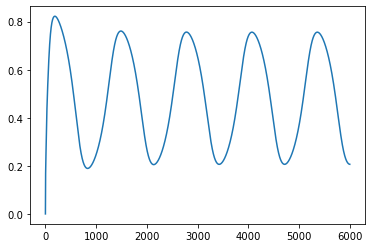

In [365]:
# plt.plot(theta.dot(Xi_std.T)[:,3])
plt.plot(sol3.y[0])

In [357]:
df_term = ut.visual_param(Xi_std, descr)
df_term[df_term['la'] != 0]['la']

1         -0.418957
rr         8.368830
rb       -18.198361
ra        -3.135593
lr         2.662351
            ...    
lalarb    -6.583244
lalara     2.255717
lalalr    -0.410011
lalalb     1.981163
lalala    -1.836054
Name: la, Length: 69, dtype: float64

In [366]:
sol_res = integrate.solve_ivp(ut.sparseGalerkin, [tspan[0], tspan[-1]], pop00, method='RK45', atol=1e-10, rtol=1e-10, t_eval=tspan,args=(Xi_std.T,3))

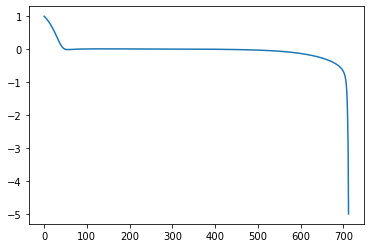

In [367]:
plt.plot(sol_res.y[0])
# plt.plot(pop_data[1])

In [31]:
theta = theta/ (np.linalg.norm(theta,axis = 0))
m,n = theta.shape
n

84

In [40]:
X_j = theta.reshape(-1,1)
X_j.shape

(18000, 1)

In [62]:
q_init = np.dot(np.linalg.pinv(theta), dpop_diff.T) 

In [92]:
x = theta @ q_init

In [94]:
x[(abs(x)-0.001) < 0] = 0
x

array([[-1.97605445,  0.00361122,  0.        ,  0.76635706, -2.76287798,
        -0.19997404],
       [-1.98658931,  0.0413111 ,  0.        ,  0.95286292, -2.22596332,
        -0.19655332],
       [-1.94103945,  0.08423125,  0.        ,  1.00909058, -1.86359906,
        -0.1932285 ],
       ...,
       [ 0.01191556, -0.00686715, -0.02046552, -0.0101112 ,  0.00907248,
         0.02206271],
       [ 0.01126396, -0.00671207, -0.02045045, -0.00953817,  0.00882721,
         0.02203873],
       [ 0.01061618, -0.00655775, -0.0204349 , -0.0089687 ,  0.00858306,
         0.02201412]])

In [95]:
sig_ = np.sign(x)
x[(abs(x)-0.001) < 0] = 0
sig_ * x

# np.sign(x)*max(abs(x)-0.001,0)

array([[1.97605445, 0.00361122, 0.        , 0.76635706, 2.76287798,
        0.19997404],
       [1.98658931, 0.0413111 , 0.        , 0.95286292, 2.22596332,
        0.19655332],
       [1.94103945, 0.08423125, 0.        , 1.00909058, 1.86359906,
        0.1932285 ],
       ...,
       [0.01191556, 0.00686715, 0.02046552, 0.0101112 , 0.00907248,
        0.02206271],
       [0.01126396, 0.00671207, 0.02045045, 0.00953817, 0.00882721,
        0.02203873],
       [0.01061618, 0.00655775, 0.0204349 , 0.0089687 , 0.00858306,
        0.02201412]])

In [124]:
def soft_thresholding(X, lambda_, zero_idx):
    sig_ = np.sign(X)
    X[(abs(X)-0.001) < 0] = 0
    return sig_ * X
    # temp_compare = X.T.copy()
    # for i in range(len(X)):
    #     if abs(X[i]) - lambda_ < 0:
    #         temp_compare[:, [i]] = 0
    #     else:
    #         temp_compare[:, [i]] = abs(X[i]) - lambda_
    # # tmp_compare = X[np.where(abs(X) - lambda_ > 0)]
    # # tmp_compare = np.expand_dims(tmp_compare, axis =1)
    # print(lambda_)
    # return np.multiply(np.sign(X), temp_compare.T)

def ADM(lib_null, q_init, lambda_, MaxIter, tol, zero_idx):
    q = q_init.copy()
    for i in range(MaxIter):
        q_old = q.copy()
        x = soft_thresholding(lib_null @ q_init, lambda_, zero_idx)
        temp_ = lib_null.T @ x
        # q = temp_ / np.linalg.norm(temp_, 2)
        q = np.linalg.pinv(temp_).dot(np.linalg.norm(temp_, 2)).T

        res_q = np.linalg.norm(q_old - q, 2)
        # print(res_q)
        # print(tol)

        if res_q <= tol:
            return q

In [132]:
df_prior.shape

(84, 6)

In [133]:
res_ = ADM(theta, df_prior, 0.00001, 10000, 1e-20)
res_[:,0]

42474.6624852864
1e-20
0.0
1e-20


array([-4.26640169, -4.91123475,  3.96196832,  0.50412308, -0.33917914,
       -2.80732618, -5.71119175, -6.50456837,  2.75952812,  8.66984987,
       -3.57142555,  3.6011272 ,  0.20264881, -2.27937138,  4.46100424,
        1.72653837,  2.59858269, -6.19188591, -1.93264862,  0.94492334,
        0.95644863, -1.51533349, -2.48474735,  2.47657268,  5.39360789,
       -1.03070254, -2.19796061, -7.92223929, -7.96294819, -0.55621575,
        6.37330575, 10.8003528 , -4.62126137, -4.01477041,  4.22291159,
       -1.07390817,  4.72200086, -0.50206127, -3.37446502,  5.39815126,
        8.62070062, -2.0253795 ,  2.88230147,  2.08008515,  0.67908773,
        3.64845859,  5.85830709,  4.96611709, -7.21214123, -4.33769786,
        3.34545114, -1.37040984,  2.48714627,  1.69411022, -3.34090349,
       -1.19486607,  3.65009369,  4.60800214, -4.78131177, -4.15341269,
        1.43065645,  2.1377784 , -0.86416882, -3.56632812,  2.67795659,
        6.49958282, -0.83303748,  4.3820217 ,  7.51664358,  0.62

In [157]:
dic = {}
dic['la'], dic['ra'] = ['rb', 'rr'], ['lb','lr']
dic['lb'], dic['rb'] = ['ra', 'rr'], ['la', 'lr']
dic['lr'], dic['rr'] = ['ra', 'rb'], ['la', 'lb']
df_prior, remain_index = ut.bulid_prior(label, theta, descr, dic)


In [161]:
zero_idx = []
for i in range(6):
    tmp = [j for j in range(84) if j not in remain_index[i]]
    zero_idx.append(tmp)

In [129]:
# important, keep
theta_dic = {}
for i, term in enumerate(label):
    theta_dic[term] = theta[:, remain_index[i]]
    clf
    # clf = linear_model.Lasso(alpha=0.0002, fit_intercept=False, max_iter=1e4)
    # clf.fit(theta_dic[term],dpop_diff[i].T)
    # Xi_curr = clf.coef_
    Xi_curr = ut.sparsifyDynamics(theta_dic[term], np.expand_dims(dpop_diff[i].T,1), 0.001)
    df_prior[term].iloc[remain_index[i]] = Xi_curr.T[0]

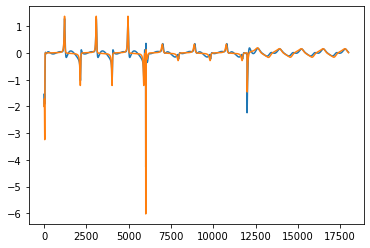

In [78]:
plt.plot(theta.dot(df_prior['la']))
plt.plot(dpop_data[0])

In [77]:
df_prior
df_prior[df_prior['lb'] != 0]['lb']

1          -2.809050
rb          7.059771
lr         -1.884942
lb         -6.655747
la         13.295790
rbrb        4.317904
lrlr        7.414736
lbrb       65.126278
lblr       -3.191597
lblb       55.667588
larb      -27.615751
lalr        1.383795
lalb      -38.152171
lala      -12.218329
rbrbrb     -8.742608
lrlrlr     -6.918258
lbrbrb    -80.552410
lblrlr     -0.893243
lblbrb   -109.575490
lblblr      3.515202
lblblb    -49.384767
larbrb     17.611286
lalrlr      2.325340
lalbrb     47.894141
lalblr     -8.641792
lalblb      9.527956
lalarb      3.855703
lalalr     -3.553475
lalalb     15.811852
lalala      5.927246
Name: lb, dtype: float64

In [39]:
dpop_diff = ut.time_different(dt, dpop, sol.y)

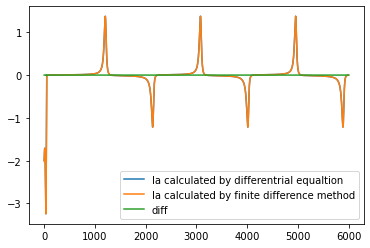

In [70]:
plt.plot(dpop[0], label='la calculated by differentrial equaltion')
plt.plot(dpop_diff[0], label= 'la calculated by finite difference method')
plt.plot(dpop_diff[0] - dpop[0], label='diff')
plt.legend()

In [32]:
theta_dic['la'].shape

(6000, 30)

In [52]:
# linear regression applied
clf = linear_model.Lasso(alpha=1e-5, fit_intercept=False, max_iter=1e5)
clf.fit(theta_dic['la'],dpop_diff[0].T)
Xi = clf.coef_

In [14]:
sol_res = integrate.solve_ivp(ut.sparseGalerkin, [tspan[0], tspan[-1]], pop0, method='RK45', atol=1e-10, rtol=1e-10, t_eval=tspan,args=(df_prior,3))

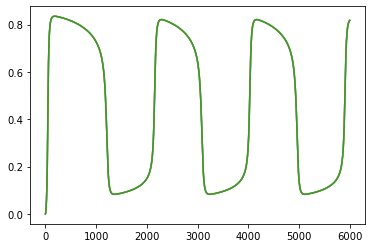

In [20]:
plt.plot(sol_res.y[1])
plt.plot(sol.y[1])
plt.plot(sol_res.y[1])

In [17]:
df_prior[df_prior['la'] !=0]['la']

ra        -752.367083
lr           2.967300
lb         966.076402
la          25.405327
rara      1416.147844
lrlr       -29.752536
lbra     -1748.914498
lblr        11.537814
lblb       -18.723555
lara      1335.323513
lalr       116.702013
lalb     -1870.898969
lala       -43.030907
rarara    -539.201156
lrlrlr      -0.323584
lbrara     309.430358
lblrlr      35.191427
lblbra     604.469414
lblblr     -16.734270
lblblb    -237.752399
larara   -1094.869491
lalrlr      28.056838
lalbra    1396.577803
lalblr     -54.246749
lalblb     -34.087358
lalara    -608.598137
lalalr    -115.883671
lalalb     908.386338
lalala      15.624450
Name: la, dtype: float64

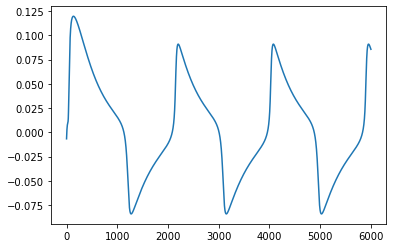

In [111]:
plt.plot(theta.dot(df_prior)[0])

In [117]:
 label = ['la', 'lb', 'lr', 'ra']
 theta_la, descr_la = ut.lib_terms(sol.y,3,label)

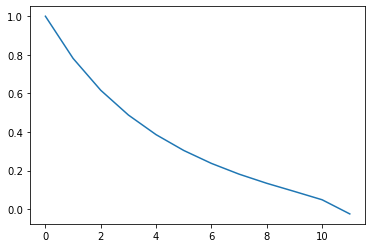

In [89]:
plt.plot(sol_res.y[0])

In [94]:
Xi_new = Xi/ theta_norm

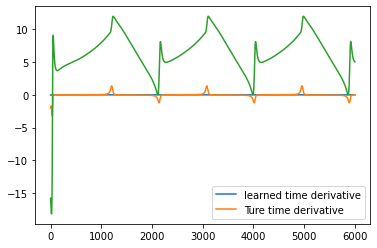

In [95]:
plt.plot(theta_new.dot(Xi_new.T)[:,0], label="learned time derivative")
plt.plot(dpop[0], label="Ture time derivative")
plt.plot(theta.dot(Xi.T)[:,0] - dpop[0])
plt.legend()

In [97]:
sol_std = integrate.solve_ivp(ut.sparseGalerkin, [tspan[0], tspan[-1]], pop0, method='RK45',atol=1e-10, rtol=1e-10, t_eval=tspan,args=(Xi_std,3))
sol_res = integrate.solve_ivp(ut.sparseGalerkin, [tspan[0], tspan[-1]], pop0, method='RK45', atol=1e-10, rtol=1e-10, t_eval=tspan,args=(Xi_new.T,3))

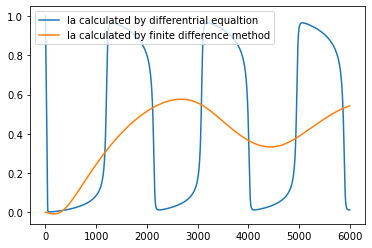

In [101]:
plt.plot(sol_std.y[0], label='la calculated by differentrial equaltion')
plt.plot(sol_res.y[2],label ='la calculated by finite difference method')
plt.legend()

dla: rr, lr, rb^2, lr^2, rb*rr^2, ra^2*rr, lr*ra^2, lb^3, la*ra*rr, la*ra^2, la^2*rr, la^2*lr, la^3


dla True system: lr, la*lr, ra*lr, la, la*lb^2


dlb: ra, lb, rb^2, ra^2, lr^2, lb^2, lr*rb^2, lb^2*rb, la*lb^2, la*lb*lr


dlb True system: lb, rb, lb^2, lb*rb, la*lb^2


dlr: ra, lr, lb, lr^2, lb*rr, la^3


dlr True system: lr, rr, lb*lr, lb*rr

In [102]:
import pandas as pd
def visual_param(Xi, descr):
    small_idx = abs(Xi) < 1e-4
    Xi[small_idx] = 0
    new_set =  [x.replace('(', '').replace(']', '') for x in descr] 
    name_s = ['la', 'lb', 'lr', 'ra', 'rb', 'rr']
    label = []
    for str_ in new_set[2:]:
        idx_ = [int(x) for x in str_.split(') [')[0].split(',')]
        lab = ""
        for idx, i in enumerate(idx_):
            j = i
            while j > 0:
                lab += name_s[idx]
                j -= 1
        label.append(lab)

    term_label = ['1'] + label

    df_term = pd.DataFrame(Xi.T, index=term_label, columns=name_s)

    return df_term
df_term = visual_param(Xi_new, descr)

In [104]:
df_term.sort_values(by=['la'])['la'][:5], df_term.sort_values(by=['la'])['la'][-5:]

(larara   -0.357012
 lara     -0.294775
 lalbrr   -0.257251
 rarb     -0.222214
 lararr   -0.212833
 Name: la, dtype: float64,
 rarrrr    0.192447
 lalara    0.205762
 rara      0.231721
 lararb    0.325905
 lalrra    0.341565
 Name: la, dtype: float64)

In [44]:
dic = {}
dic['la'] = ['rb', 'rr']
dic['lb'] = ['ra', 'rr']
dic['lr'] = ['ra', 'rb']
dic['ra'] = ['lb', 'lr']
dic['rb'] = ['la', 'lr']
dic['rr'] = ['la', 'lb']

In [53]:
for term in ['la']: # la
    idx_prev =  df_prior.index# [1, 'la', 'lb']
    x_new = set()
    for i, s in enumerate(dic[term]):
        lst_idx = [p.find(s) for p in idx_prev]
        x, = np.where(np.array(lst_idx) == -1)
        if i == 0:
            x_new = set(x)
        else:
            x_new = x_new.intersection(x)
    df_prior[term].iloc[list(x_new)] = 1

In [52]:
df_prior[term].iloc[list(x_new)] = 1

In [49]:
df_prior[term].iloc[list(x_new)] = 1

In [35]:
df_prior.index

Index(['1', 'rr', 'rb', 'ra', 'lr', 'lb', 'la', 'rrrr', 'rbrr', 'rbrb', 'rarr',
       'rarb', 'rara', 'lrrr', 'lrrb', 'lrra', 'lrlr', 'lbrr', 'lbrb', 'lbra',
       'lblr', 'lblb', 'larr', 'larb', 'lara', 'lalr', 'lalb', 'lala',
       'rrrrrr', 'rbrrrr', 'rbrbrr', 'rbrbrb', 'rarrrr', 'rarbrr', 'rarbrb',
       'rararr', 'rararb', 'rarara', 'lrrrrr', 'lrrbrr', 'lrrbrb', 'lrrarr',
       'lrrarb', 'lrrara', 'lrlrrr', 'lrlrrb', 'lrlrra', 'lrlrlr', 'lbrrrr',
       'lbrbrr', 'lbrbrb', 'lbrarr', 'lbrarb', 'lbrara', 'lblrrr', 'lblrrb',
       'lblrra', 'lblrlr', 'lblbrr', 'lblbrb', 'lblbra', 'lblblr', 'lblblb',
       'larrrr', 'larbrr', 'larbrb', 'lararr', 'lararb', 'larara', 'lalrrr',
       'lalrrb', 'lalrra', 'lalrlr', 'lalbrr', 'lalbrb', 'lalbra', 'lalblr',
       'lalblb', 'lalarr', 'lalarb', 'lalara', 'lalalr', 'lalalb', 'lalala'],
      dtype='object')

In [369]:
list(dic.keys())

['la', 'lb', 'lr', 'ra', 'rb', 'rr']

In [359]:
for term in ['la']: # la
    idx_prev = idx_ # [1, 'la', 'lb']
    x_new = set()
    for i, s in enumerate(dic[term]):
        lst_idx = [p.find(s) for p in idx_prev]
        x, = np.where(np.array(lst_idx) == -1)
        if i == 0:
            x_new = set(x)
        else:
            x_new = x_new.intersection(x)
    # ynew = np.vstack(y)
    # df_prior[term].iloc[ynew] = 0

In [353]:
y  = np.unique(x_new)

In [361]:
df_prior[term].iloc[list(x_new)] = 1

In [45]:
X.shape

(442, 10)

In [46]:
y.shape

(442, 1)